In [1]:
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import time
import itertools
import re
import sys
import pandas as pd
import seaborn as sns
from sympy import *
from sympy.utilities.autowrap import autowrap
import re
from scipy.integrate import odeint


%matplotlib inline

In [2]:
###################################################
# Part I - USER DEFINED VARIABLES
###################################################

# Define the model of interest
MODEL = "M019"
TRMNT = "CDDP"
DATE = "20220314_111222"

# Path to files
PathToModelOutput = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/"
PathToGenDataOutput = "/Users/muriel/Documents/LACDR/Projects/PHH/Data/VirtualDonors/v2_firstRevision/VaryParmsData/"
PathToRDataOutput = "/Users/muriel/Documents/LACDR/Projects/PHH/Data/VirtualDonors/v2_firstRevision/VaryR_ParmSets/"
#PathToVirtualSamples = "/Users/muriel/Documents/LACDR/Projects/DDP/Analysis/00_BioSpyder/Output/VirtualSamples/"

# Define the path to the input folder containing the model output, i.e. the path where the MODEL directory is located
selectionFileLow = "20220322_M019Model_parmset3_ParmPertSelection_low_8hr_20220322_varyR_VaryParameters.csv"
selectionFileMed = "20220322_M019Model_parmset3_ParmPertSelection_med_8hr_20220322_varyR_VaryParameters.csv"
selectionFileHigh = "20220322_M019Model_parmset3_ParmPertSelection_high_8hr_20220322_varyR_VaryParameters.csv"

# Define the path to the ode system file, i.e. the path where the input files are located
PathToModelInput = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/" # Write down the path to the folder that
# contains the file with the ODE system



In [3]:
# Transpose the data
def doTranspose(data, run = "first"):
    data = data.T
    data.columns = data.iloc[0]
    data = data.drop(data.index[0])
    if run == "first":
        data = data.iloc[1:51]
    elif run == "second":
        data = data.iloc[51:101]
    elif run == "third":
        data = data.iloc[101:151]
    return(data)


In [4]:
inputFolder = PathToModelOutput + MODEL + "/" + TRMNT

# Define paths to data
Dates = os.listdir(inputFolder)
parmset_paths = []
for Date in Dates:
    path1 = inputFolder + "/" + Date + "/"
    if os.path.isdir(path1):
            if os.path.isdir(path1):
                # Get the files that contain the parameter estimates
                files = os.listdir(path1)
                for file in files:
                    if re.search("\d{1}.\d{2}.csv", file):
                        parmset_paths.append(path1 + file)
                        print(path1+file)
                    elif re.search("settings.txt", file):
                        #setting_paths.append(path2 + file)
                        settingPath = path1 + file
                        print(settingPath)
                    elif re.search("metadata.txt", file):
                        metadataPath = path1 + file
                        print(metadataPath)



/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/20220314_111222_MH_M019Model_parameterEstimates_parmset1_cost_27442.21.csv
/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/metadata.txt
/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/20220314_111222_MH_M019Model_parameterEstimates_parmset13_cost_80.80.csv
/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/20220314_111222_MH_M019Model_parameterEstimates_parmset10_cost_2076.53.csv
/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/20220314_111222_MH_M019Model_parameterEstimates_parmset14_cost_24948.56.csv
/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/20220314_111222_MH_M019Model_parameterEstimates_parmset2_cost_199.38.csv
/Users/muriel/D

In [5]:
###################################################
# Part II - Run script
###################################################
# Create the input folder name

# Define Nstar and Nso from the settings file
# Read in the metadata from the metadata.txt file
with open(metadataPath) as f:
    lines = f.readlines()
    for line in lines:
        print(line)
        exec(line)

# Read in the parameters from a file
try:
    fh = open(PathToModelInput + odeFile, 'r')
    print("Path to text file with ODEs and parms exists")
    with open(PathToModelInput + odeFile) as f:
        lines = f.readlines()
    startReading = False
    stopReading = False

    print("The system parameters:")
    for i, line in enumerate(lines):
        if "####START_PARAMETERS####\n" == lines[i - 1]:
            startReading = True
        elif "####END_PARAMETERS####\n" == line:
            stopReading = True

        if startReading and not stopReading:
            print(line)
            exec(line)
except FileNotFoundError:
    sys.exit("Path to text file with ODEs and parameters does not exist.")

# Read in the settings from the settings.txt file
with open(settingPath) as g:
    lines = g.readlines()
    for line in lines:
        print(line)
        exec(line)

# Define paths to data
allDataFiles = os.listdir(inputFolder)
# Select the parameter files
parFiles = []
for file in allDataFiles:
    # if str.split(file,".")[-1] == "csv":
    if re.search(".\d{2}.csv", file): #str.split(file, ".")[-1] == "csv":
        parFiles = parFiles + [file]
print("These files will be read: \n%s" % (',\n'.join([str(i) for i in parFiles])))

# Read in the ODEs from a file
try:
    fh = open(PathToModelInput + odeFile, 'r')
    print("Path to text file with ODEs exists")
    with open(PathToModelInput + odeFile) as f:
        lines = f.readlines()
    startReading = False
    stopReading = False
    # Make a dictionary that will contain the ODEs as specified in the file
    odeDict = {}
    obsDict = {}
    print("The system of ODES:")
    for i, line in enumerate(lines):
        if "####START_ODES####\n" == lines[i - 1]:
            startReading = True
        elif "####END_ODES####\n" == line:
            stopReading = True

        if startReading and not stopReading:
            print(line)
            exec(line)
            # Make a dictionary that contains the ODEs
            # It is a match if the first chars of line are f0, f1, ..., fn
            match = re.search('^f[0-9]+', line)
            if match:
                parts = line.split(" = ")
                odeDict[parts[0]] = parts[1][:-1]

            # Make a dictionary that contains the observables
            # It is a match if the first chars of line are g0, g1, ..., gn
            match = re.search('^g[0-9]+', line)
            if match:
                parts = line.split(" = ")
                obsDict[parts[0]] = parts[1][:-1]
except FileNotFoundError:
    sys.exit("Path to text file with ODEs does not exist.")



MODEL = "M019"

DATETIME = "20220314_111222"

pathToInputFolder = "Input/withRNA/"

dataFile = "20201006_MH_CDDPdata_wFUCCI_DDP.csv"

pathToData = "Input/withRNA/20201006_MH_CDDPdata_wFUCCI_DDP.csv"

odeFile = "M019_20220311_ODE_p53model.txt"

pathToODEs = "Input/withRNA/M019_20220311_ODE_p53model.txt"

pathToOutput = "/data/muriel/Projects/PHH/Modeling/Output//M019/"

NiniP = 15

Ncpu = 15

Path to text file with ODEs and parms exists
The system parameters:


# Fixed/known parameters or initial states (optional)

# Example: < A_init = 0.1 

#            conc1 = 0 >

#

EC1 = 1

kd_p53rna = 1

P53rna_init = 1

MDM2rna_init = 1

P21rna_init = 1

BTG2rna_init = 1

P53_init = 1

MDM2_init = 1

P21_init = 1

BTG2_init = 1

kd_btg2 = 1

kd_p21 = 1

kd_mdm2 = 1



# Name of stress as it occurs in the ODE functions; either stressName = ['your stress input name'], i.e. your stress name as list, 

# or set as empty list, i.e. stressName = [], if there is no model perturbation.

# Example: < str

Stress = exposurePiecewise * Piecewise((1, (tsym > 0)), (0,True))

Stressautowrap = eval('autowrap(Stress, backend = "cython", args = (ks_dd, ks_p53rna, k_p, ks_p53, kd_mdm2rna, ks_mdm2, kd_p21rna, ks_p21, kd_btg2rna, ks_btg2, EC2, EC3, tau1, kd_dd, k_dp, kd_p53, kd_p53p, kd_p53_mdm2, kd_p53p_mdm2, ks_mdm2rna, ks_mdm2_p53p, ks_p21rna, ks_p21_p53p, Km_mdm2, Km_p21, Km_btg2, ks_btg2rna, ks_btg2_p53p, sf_p53, sf_mdm2, sf_p21, sf_btg2, offset_p53, offset_mdm2, offset_p21, offset_btg2, tsym, dose))')

These files will be read: 

Path to text file with ODEs exists
The system of ODES:


# Set of ODE equations. 

# Every ODE should be numbered with "f" and an index number starting at 0.

# Example: < f0 = ksa - kda * A

#            f1 = ksb - kdb * B

#            f2 = ksc * A * B - kdc * C >

#

f0 = ks_dd - kd_dd * DD * P53P + S

f1 = ks_p53rna - kd_p53rna * P53rna

f2 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - kd_p53_mdm2 * MDM2 * P53

f3 = k_p * P53 * DD - k_dp * P5

In [6]:
# Read in the settings from the settings.txt file
with open(settingPath) as g:
    lines = g.readlines()
    for line in lines:
        print(line)
        exec(line)

testRun = False

stressExplicit = True

stressInput = "free"

plateID_list = [[2, 3, 4], [1, 2, 3], [1, 2, 3, 4], [1, 2, 3]]

realDataColName = "data4modelReal"

interpolDataColName = "data4modelInterpol"

interpolTimeColName = "timepoints"

realTimeColName = "timeAfterExposure"

palette = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'r', 'g']

doseList = [1, 2.5, 5]

doseFunctionType = "expDecay"

markers = ['o', 'v', 's', '*', 'd', 'X', '^', '<', '>', 'o', 'v', 's', '*', 'd', 'X', '^', '<', '>']

paraList = ['ks_dd', 'ks_p53rna', 'k_p', 'ks_p53', 'kd_mdm2rna', 'ks_mdm2', 'kd_p21rna', 'ks_p21', 'kd_btg2rna', 'ks_btg2', 'EC2', 'EC3', 'tau1', 'kd_dd', 'k_dp', 'kd_p53', 'kd_p53p', 'kd_p53_mdm2', 'kd_p53p_mdm2', 'ks_mdm2rna', 'ks_mdm2_p53p', 'ks_p21rna', 'ks_p21_p53p', 'Km_mdm2', 'Km_p21', 'Km_btg2', 'ks_btg2rna', 'ks_btg2_p53p', 'sf_p53', 'sf_mdm2', 'sf_p21', 'sf_btg2', 'offset_p53', 'offset_mdm2', 'offset_p21', 'offset_btg2']

paraFreeList = ['DD_init', 'P53P_init', 'EC2', 'EC3'

In [7]:
# Read in the data
data_selection_low = pd.read_csv(PathToRDataOutput + selectionFileLow, sep = " ")
data_selection_med = pd.read_csv(PathToRDataOutput + selectionFileMed, sep = " ")
data_selection_high = pd.read_csv(PathToRDataOutput + selectionFileHigh, sep = " ")


In [35]:
data_selection_high.head(5)

,ParName,est_value,r11_newValue1_v0.2_rfactor1,r11_newValue2_v0.2_rfactor1,r11_newValue3_v0.2_rfactor1,r11_newValue4_v0.2_rfactor1,r11_newValue5_v0.2_rfactor1,r11_newValue6_v0.2_rfactor1,r11_newValue7_v0.2_rfactor1,r11_newValue8_v0.2_rfactor1,...,r889_newValue41_v0.2_rfactor1,r889_newValue42_v0.2_rfactor1,r889_newValue43_v0.2_rfactor1,r889_newValue44_v0.2_rfactor1,r889_newValue45_v0.2_rfactor1,r889_newValue46_v0.2_rfactor1,r889_newValue47_v0.2_rfactor1,r889_newValue48_v0.2_rfactor1,r889_newValue49_v0.2_rfactor1,r889_newValue50_v0.2_rfactor1
1,DD_init,20.686236,13.061687,25.168866,17.360444,18.277021,21.497263,17.837047,13.957567,25.458644,...,30.525839,27.812977,17.608541,40.784697,24.821948,16.029301,21.215449,16.596599,19.387961,21.101910
2,P53rna_init,1.000000,1.273851,0.932518,0.950372,1.135264,1.206232,0.817863,1.031896,1.382530,...,0.930941,0.835958,2.694115,0.799847,0.730130,1.297428,0.937939,0.752928,1.273656,1.128939
3,P53_init,1.000000,1.155031,0.848035,1.183687,1.373130,1.138095,1.061534,1.906266,0.744510,...,1.122385,0.384337,3.442888,0.319508,0.586834,2.520046,0.770601,0.899911,0.964230,0.601860
4,P53P_init,1.759608,2.299488,1.517727,2.255874,2.171912,1.605620,2.383110,1.937315,1.468413,...,0.972140,1.421302,4.011164,1.274443,1.418157,2.967791,1.234343,1.877985,1.916239,1.105765
5,MDM2rna_init,1.000000,1.144446,0.977341,0.732234,0.839062,0.886690,0.869092,0.888087,0.921886,...,0.593713,0.980209,1.946794,1.078462,0.674503,1.182947,0.962119,0.791109,1.129269,0.873531


In [36]:
data_selection_low.head(5)

,ParName,est_value,r11_newValue1_v0.2_rfactor1,r11_newValue2_v0.2_rfactor1,r11_newValue3_v0.2_rfactor1,r11_newValue4_v0.2_rfactor1,r11_newValue5_v0.2_rfactor1,r11_newValue6_v0.2_rfactor1,r11_newValue7_v0.2_rfactor1,r11_newValue8_v0.2_rfactor1,...,r530_newValue41_v0.2_rfactor1,r530_newValue42_v0.2_rfactor1,r530_newValue43_v0.2_rfactor1,r530_newValue44_v0.2_rfactor1,r530_newValue45_v0.2_rfactor1,r530_newValue46_v0.2_rfactor1,r530_newValue47_v0.2_rfactor1,r530_newValue48_v0.2_rfactor1,r530_newValue49_v0.2_rfactor1,r530_newValue50_v0.2_rfactor1
1,DD_init,20.686236,13.061687,25.168866,17.360444,18.277021,21.497263,17.837047,13.957567,25.458644,...,21.777387,16.077659,19.403069,16.584874,24.922547,20.130748,24.585085,31.274874,16.678199,37.219490
2,P53rna_init,1.000000,1.273851,0.932518,0.950372,1.135264,1.206232,0.817863,1.031896,1.382530,...,0.570852,1.115483,0.951330,1.353956,0.815200,1.269397,0.758430,0.691668,0.976550,0.750812
3,P53_init,1.000000,1.155031,0.848035,1.183687,1.373130,1.138095,1.061534,1.906266,0.744510,...,0.786385,1.678829,1.031836,1.719898,0.838327,1.085389,0.623224,0.408281,1.211624,0.542443
4,P53P_init,1.759608,2.299488,1.517727,2.255874,2.171912,1.605620,2.383110,1.937315,1.468413,...,1.225631,1.685274,1.945704,2.172301,1.777137,1.660912,1.990916,1.183424,1.404682,1.021626
5,MDM2rna_init,1.000000,1.144446,0.977341,0.732234,0.839062,0.886690,0.869092,0.888087,0.921886,...,0.678329,1.032148,1.018237,0.781352,1.117264,0.816835,1.050605,1.113328,1.733280,1.308920


In [28]:
# Make simulations with the parameter estimates of dfSub4
allSimus = []
allSimusMapped = []
dfSub4 = doTranspose(data_selection_high)

In [29]:
dfSub4;

In [30]:
def replaceStateVars(stateList, d, string=""):
    dictExec = d
    # Replace the state variables by z[0], z[1], ..., z[n]
    for i, stateVar in enumerate(stateList):
        result = []
        for j, key in enumerate(dictExec.keys()):
            splitres = re.split(r"([^a-zA-Z]" + stateVar + "[^a-zA-Z])", dictExec[key])
            subres = []
            for res in splitres:
                if re.search(r"((^|[^a-zA-Z])" + stateVar + "([^a-zA-Z]|$))", res):
                    subres = subres + [re.sub(stateVar, string + str(i) + "]", res)]
                else:
                    subres = subres + [res]
            joinedres = "".join(subres)
            dictExec[key] = joinedres
    return dictExec


def modelSimulation(z, t, args):
    [odeDictExec, Stressautowrap, p] = args

    # Stress level
    sText = "Stressautowrap("
    for i, var in enumerate(p):
        if i < len(p) - 1:
            sText = sText + str(var) + ","
        else:
            sText = sText + str(var) + ")"

    # Assign Stressautowrap to Stress parameter
    sText = stressName[0] + " = " + sText
    exec(sText)
    #S = eval(sText)
    # print("Executed: S = %s" % sText)

    # Get the correct order of f equations:
    ordr = []
    for i in range(0, len(stateList)):
        ordr.append('f' + str(i))

    # Evaluate the ODEs
    output = []
    for i, key in enumerate(ordr):
        output.append(eval(odeDictExec[key]))

    # Output
    dzdt = output
    return dzdt


# Define t
t = np.array(tspan)


In [31]:
try:
    for row in range(0,dfSub4.shape[0]):
        pAllNew = np.array(dfSub4.iloc[row,:])
        
        # Make the parameters global variables
        for i,par in enumerate(np.array(dfSub4.columns)):
            sText = par + " = " + str(pAllNew[i])
            #print(sText)
            exec(sText)
        
        # Remove fixed parameters
        pAllNew = np.delete(pAllNew,[1,2,4,5,6,7,8,9,13,14,15,16])

        # initial condition
        # Make a global variable z that contains the initial conditions, for example:
        sText = "z = ["
        # allIniStates = stateOList+stateOKnownNameList
        allIniStates = allIniStatesList
        for stateVari in np.arange(0,len(allIniStates),1):
            if stateVari < len(allIniStates) - 1:
                sText = sText + allIniStates[stateVari] + ","
            else:
                sText = sText + allIniStates[stateVari] + "]"
        exec(sText)
        # print("Executed: %s" % sText)

        # Replace the state variables in odeDict by z[0], z[1], ..., z[n]
        odeDictExec = replaceStateVars(stateList, odeDict, string="z[")
        # Replace the state variables in odeDict by z[0], z[1], ..., z[n]
        obsDictExec = replaceStateVars(stateList, obsDict, string="simu[:,")

        # Simulate the model with the estimated parameters (simulations) and transform the output
        # by using the mapping g (mappedSimu)
        simulations = np.zeros((len(doseList), len(t), len(stateList)))
        mappedSimu = np.zeros((len(doseList), len(t), len(obsList)))
        for i, dose in enumerate(doseList):  # enumerate(outputParms[Ns:Ns+Nd]):
            if Nstar == 0:
                p = pAllNew[Nse:].tolist() + ["t"] + [dose]
            else:
                p = pAllNew[-Nstar:].tolist() + pAllNew[Nse:-Nstar].tolist() + ["t"] + [dose]
            args = [odeDictExec, Stressautowrap, p]
            simu = odeint(modelSimulation, z, t, args=(args,))
            simulations[i, :, :] = simu
            if len(obsList) > 1:
                sText = "mappedSimu[i,:,:] = np.transpose(np.array(["
                for j, key in enumerate(sorted(obsDictExec.keys())):
                    if j < len(obsList) - 1:
                        sText = sText + obsDictExec[key] + ","
                    else:
                        sText = sText + obsDictExec[key] + "]))"
                exec(sText)
                # print("Executed: %s" % sText)
            else:
                sText = "mappedSimu[i,:,0] = " + list(obsDictExec.values())[0]
                exec(sText)
                # print("Executed: %s" % sText)
        
        # print(mappedSimu)
        allSimus.append(simulations)
        allSimusMapped.append(mappedSimu)

except:
    print("passed")

In [32]:
meanSimu = np.mean(allSimus, axis=0)
meanMappedSimu = np.mean(allSimusMapped, axis=0)

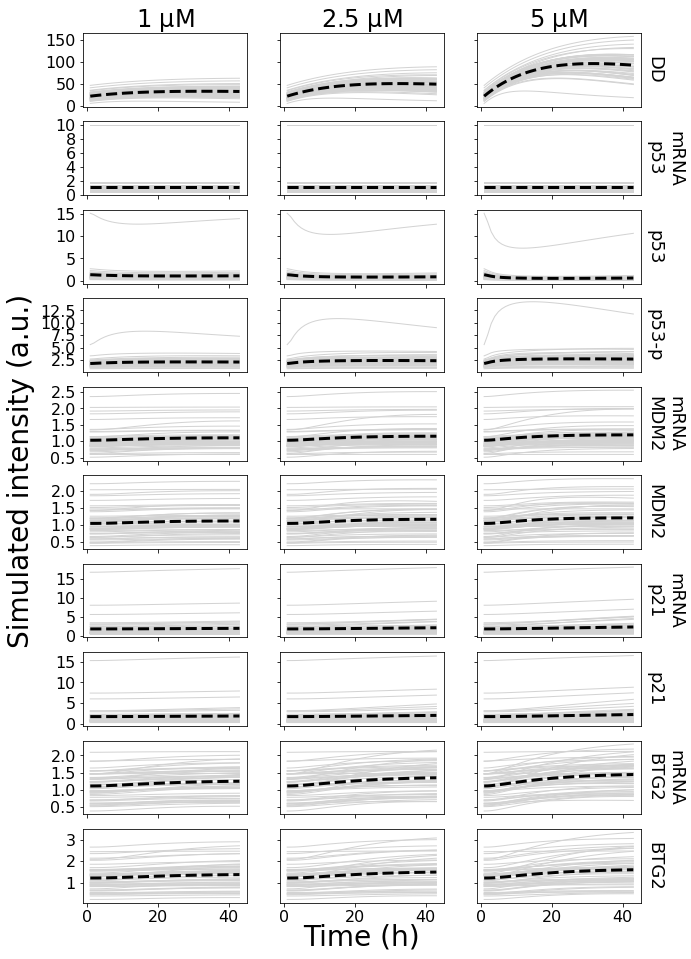

Plotting done! Script ended.


In [33]:
# Make a plot that plots the best fits and the mean of those fits
# Plot the simulations of the state variables together with the data mean
ylabels = ['DD', 'mRNA\np53', 'p53', 'p53-p', 'mRNA\nMDM2', 'MDM2', 'mRNA\np21', 'p21', 'mRNA\nBTG2', 'BTG2']

fig, ax = plt.subplots(Ns, len(doseList), sharex='col', sharey='row')
if len(doseList) > 1:
    plot_titles = [(str(i) + " $\mathrm{\mu M}$") for i in doseList]
else:
    plot_titles = str(doseList[0]) + " uM"

begin = 0
#abc = 1
if len(doseList) > 1:
    for i, dose in enumerate(doseList):
        for j, stateVar in enumerate(ylabels):
            # Plot the model simulation
            for mappedsimu in allSimus:
                #print("plotted %i!" % abc)
                #abc += 1
                ax[j, i].plot(t, mappedsimu[i, :, j], label=stateVar, color="#D3D3D3", linewidth=1)
                ax[j, i].locator_params(axis='y', nbins=6)
            ax[j, i].plot(t, meanSimu[i, :, j], '--',label=stateVar, color="#000000", linewidth=3)
            ax[j, len(doseList) - 1].set_ylabel(stateVar, rotation=-90, fontsize=18)
            ax[j, len(doseList) - 1].yaxis.set_label_coords(1.03, 0.5)
            ax[j, i].tick_params(labelsize=16)
        begin += Nt
        ax[0, i].set_title(plot_titles[i],
                           fontdict={'fontsize': 24})

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.2)
fig.set_figheight(16)
fig.set_figwidth(10)
#fig.suptitle('Model vs. Data', fontsize=28)
fig.text(0.02, 0.5, 'Simulated intensity (a.u.)', va='center', rotation='vertical', fontsize=28)

# hide tick and tick label of the big axes
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (h)", fontsize=28)
#plt.savefig(outPath + MODEL + "_" + TRMNT +"_PlotOf" + str(dfSub4.shape[0]) + "BestModels.pdf")
plt.show()
#plt.close()

print("Plotting done! Script ended.")
fig.savefig(PathToModelInput + "Notebooks/Figures/FigS9_VirtualSampleExamples.pdf", bbox_inches='tight')

